In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69)
os.environ["PYTHONHASHSEED"] = str(69)

In [3]:
df = pd.read_csv('./data/dailySentiment.csv')
df.head()

,Unnamed: 0,Day,Price,Sentiment
0,4507,20150105,3.22,-0.534077
1,4508,20150106,2.98,-0.337025
2,4509,20150107,3.08,-0.065357
3,4510,20150108,2.92,-0.326590
4,4511,20150109,2.96,-0.374404


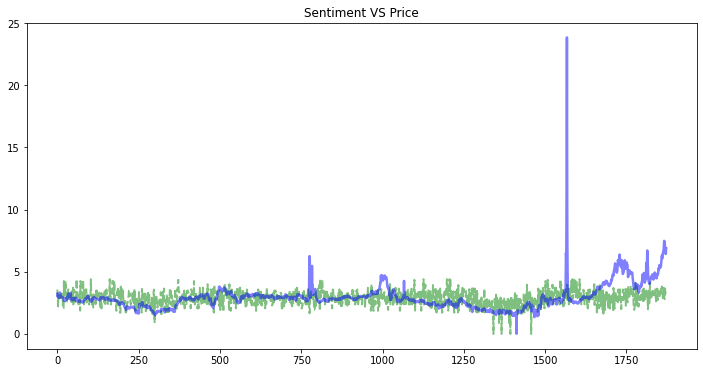

In [4]:
avg = sum(list(df.Price))/len(list(df.Price))
sen = list(df.Sentiment)
price = list(df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()

In [5]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j], df.Sentiment[i+j]])
        res.append([0, df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [6]:
SPLIT = 0.85
xVal, yVal = singleStepSampler(df, 20)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([1575, 21, 2]), TensorShape([278, 21, 2]))

In [6]:
(xTrain[0], yTrain[0])

(<tf.Tensor: shape=(21, 2), dtype=float64, numpy=
 array([[ 3.22      , -0.53407659],
        [ 2.98      , -0.33702523],
        [ 3.08      , -0.06535698],
        [ 2.92      , -0.32659015],
        [ 2.96      , -0.37440371],
        [ 2.9       , -0.28797958],
        [ 2.92      , -0.32659015],
        [ 3.15      , -0.3090599 ],
        [ 3.32      , -0.28900051],
        [ 3.11      , -0.38719366],
        [ 2.94      , -0.35766462],
        [ 2.94      , -0.35766462],
        [ 2.95      , -0.44056478],
        [ 2.96      , -0.37440371],
        [ 2.92      , -0.32659015],
        [ 2.96      , -0.37440371],
        [ 2.89      , -0.39860696],
        [ 2.88      , -0.01438307],
        [ 2.88      , -0.01438307],
        [ 2.88      , -0.01438307],
        [ 0.        , -0.76904183]])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.67>)

In [8]:
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [9]:
hybridModel = tf.keras.Sequential()
hybridModel.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(21, 2)))
hybridModel.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
hybridModel.add(tf.keras.layers.LSTM(256, return_sequences=True))
hybridModel.add(tf.keras.layers.Flatten())
hybridModel.add(tf.keras.layers.Dense(128, activation='relu'))
hybridModel.add(tf.keras.layers.Dense(1, activation='linear'))
hybridModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [10]:
hybridModel.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 12s 14ms/step - loss: 0.3350 - mse: 0.6349 - mae: 0.3350 - smape: 0.1354
Epoch 2/50
50/50 [==============================] - 0s 10ms/step - loss: 0.2164 - mse: 0.4209 - mae: 0.2164 - smape: 0.0744
Epoch 3/50
50/50 [==============================] - 1s 10ms/step - loss: 0.1991 - mse: 0.3813 - mae: 0.1991 - smape: 0.0686
Epoch 4/50
50/50 [==============================] - 0s 9ms/step - loss: 0.2018 - mse: 0.3604 - mae: 0.2018 - smape: 0.0697
Epoch 5/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1722 - mse: 0.3166 - mae: 0.1722 - smape: 0.0592
Epoch 6/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1493 - mse: 0.2891 - mae: 0.1493 - smape: 0.0505
Epoch 7/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1872 - mse: 0.2979 - mae: 0.1872 - smape: 0.0651
Epoch 8/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1386 - mse: 0.2569 - mae: 0.1386 - smape: 0.0476
Epoch 9/50
5

In [15]:
hybridModel.save('./models/singleStepDailyHybrid.h5')

In [11]:
hybridModel = tf.keras.models.load_model('./models/singleStepDailyHybrid.h5', custom_objects={'smape': smape})

In [13]:
LSTMModel = tf.keras.Sequential()
LSTMModel.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(21, 2)))
LSTMModel.add(tf.keras.layers.LSTM(128, activation='relu'))
LSTMModel.add(tf.keras.layers.Flatten())
LSTMModel.add(tf.keras.layers.Dense(128, activation='relu'))
LSTMModel.add(tf.keras.layers.Dense(1, activation='linear'))
LSTMModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [14]:
LSTMModel.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 9s 80ms/step - loss: 0.3662 - mse: 0.7491 - mae: 0.3662 - smape: 0.1580
Epoch 2/50
50/50 [==============================] - 5s 102ms/step - loss: 0.2168 - mse: 0.4107 - mae: 0.2168 - smape: 0.0737
Epoch 3/50
50/50 [==============================] - 5s 97ms/step - loss: 0.1724 - mse: 0.3536 - mae: 0.1724 - smape: 0.0580
Epoch 4/50
50/50 [==============================] - 3s 68ms/step - loss: 0.1826 - mse: 0.3439 - mae: 0.1826 - smape: 0.0620
Epoch 5/50
50/50 [==============================] - 4s 70ms/step - loss: 0.1583 - mse: 0.3043 - mae: 0.1583 - smape: 0.0539
Epoch 6/50
50/50 [==============================] - 3s 70ms/step - loss: 0.1718 - mse: 0.2876 - mae: 0.1718 - smape: 0.0592
Epoch 7/50
50/50 [==============================] - 3s 69ms/step - loss: 0.1334 - mse: 0.2458 - mae: 0.1334 - smape: 0.0456
Epoch 8/50
50/50 [==============================] - 4s 71ms/step - loss: 0.1403 - mse: 0.2522 - mae: 0.1403 - smape: 0.0482
Epoch 9

In [16]:
LSTMModel.save('./models/singleStepDailyLSTM.h5')

In [14]:
LSTMModel = tf.keras.models.load_model('./models/singleStepDailyLSTM.h5', custom_objects={'smape': smape})

In [23]:
CNNModel = tf.keras.Sequential()
CNNModel.add(tf.keras.layers.Conv1D(32, kernel_size=(2), input_shape=(21, 2)))
CNNModel.add(tf.keras.layers.Flatten())
CNNModel.add(tf.keras.layers.Dense(128, activation='relu'))
CNNModel.add(tf.keras.layers.Dense(1, activation='linear'))
CNNModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [24]:
CNNModel.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 1s 8ms/step - loss: 0.4290 - mse: 0.6915 - mae: 0.4290 - smape: 0.1559
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1916 - mse: 0.3236 - mae: 0.1916 - smape: 0.0656
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1793 - mse: 0.3027 - mae: 0.1793 - smape: 0.0606
Epoch 4/50
50/50 [==============================] - 0s 9ms/step - loss: 0.2041 - mse: 0.2983 - mae: 0.2041 - smape: 0.0711
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1357 - mse: 0.2595 - mae: 0.1357 - smape: 0.0452
Epoch 6/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1348 - mse: 0.2507 - mae: 0.1348 - smape: 0.0454
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1439 - mse: 0.2528 - mae: 0.1439 - smape: 0.0484
Epoch 8/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1372 - mse: 0.2504 - mae: 0.1372 - smape: 0.0464
Epoch 9/50
50/50

In [25]:
CNNModel.save('./models/singleStepDailyCNN.h5')

In [13]:
CNNModel = tf.keras.models.load_model('./models/singleStepDailyCNN.h5', custom_objects={'smape': smape})

In [15]:
print(hybridModel.evaluate(xTest, yTest))
print(LSTMModel.evaluate(xTest, yTest))
print(CNNModel.evaluate(xTest, yTest))

9/9 [==============================] - 0s 15ms/step - loss: 0.1464 - mse: 0.0500 - mae: 0.1464 - smape: 0.0316
[0.14636436104774475, 0.049990180879831314, 0.14636436104774475, 0.03155473247170448]
9/9 [==============================] - 1s 28ms/step - loss: 0.1538 - mse: 0.0629 - mae: 0.1538 - smape: 0.0328
[0.15376919507980347, 0.06294945627450943, 0.15376919507980347, 0.032782185822725296]
9/9 [==============================] - 0s 9ms/step - loss: 0.1572 - mse: 0.0546 - mae: 0.1572 - smape: 0.0344
[0.1572456657886505, 0.05461784452199936, 0.1572456657886505, 0.03437460586428642]


In [19]:
hybrid, lstm, cnn = [], [], []
for item in xTest:
    print(np.array([item]))
    break
    hybrid.append(hybridModel.predict(np.array([item])))
    lstm.append(LSTMModel.predict(np.array([item])))
    cnn.append(CNNModel.predict(np.array([item])))

[[[ 2.7        -0.4448338 ]
  [ 2.87       -0.17962492]
  [ 2.86       -0.52417843]
  [ 2.79       -0.32171516]
  [ 2.72       -0.124277  ]
  [ 2.67       -0.76904183]
  [ 2.62       -0.47305674]
  [ 2.62       -0.47305674]
  [ 2.7        -0.4448338 ]
  [ 2.65       -0.8192868 ]
  [ 2.58       -0.32072873]
  [ 2.5        -0.29020108]
  [ 2.6        -0.37207218]
  [ 2.45       -0.66663613]
  [ 2.53       -0.46290142]
  [ 2.55       -0.79966372]
  [ 2.56       -0.54804678]
  [ 2.56       -0.54804678]
  [ 2.52       -0.49545295]
  [ 2.52       -0.49545295]
  [ 0.         -0.32072873]]]


In [17]:
hybrid

[array([[2.561816]], dtype=float32),
 array([[2.6277878]], dtype=float32),
 array([[2.5735803]], dtype=float32),
 array([[2.557107]], dtype=float32),
 array([[2.5384402]], dtype=float32),
 array([[2.4774754]], dtype=float32),
 array([[2.4775882]], dtype=float32),
 array([[2.5048916]], dtype=float32),
 array([[2.5108542]], dtype=float32),
 array([[2.5141056]], dtype=float32),
 array([[2.5399153]], dtype=float32),
 array([[2.5716798]], dtype=float32),
 array([[2.6419876]], dtype=float32),
 array([[2.6359098]], dtype=float32),
 array([[2.6091015]], dtype=float32),
 array([[2.7782805]], dtype=float32),
 array([[2.7607324]], dtype=float32),
 array([[2.728498]], dtype=float32),
 array([[2.7495534]], dtype=float32),
 array([[2.7785037]], dtype=float32),
 array([[2.785076]], dtype=float32),
 array([[2.971378]], dtype=float32),
 array([[2.9994318]], dtype=float32),
 array([[2.9347827]], dtype=float32),
 array([[2.8660958]], dtype=float32),
 array([[2.9938905]], dtype=float32),
 array([[2.998578

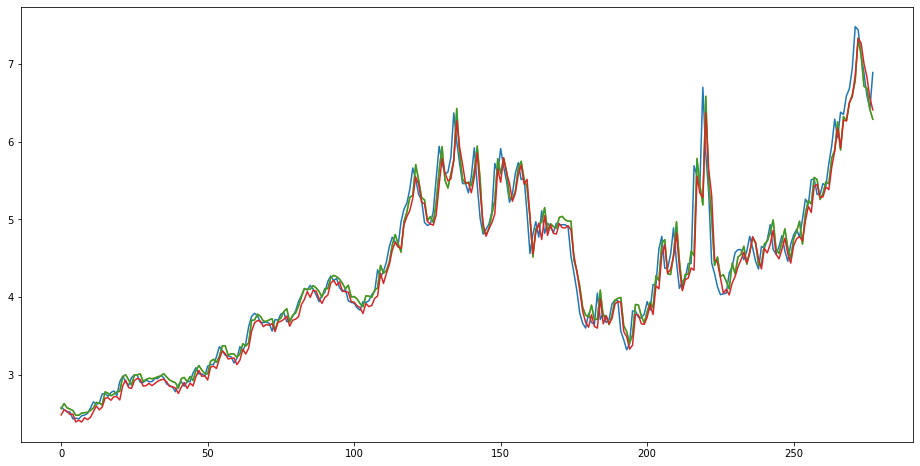

In [29]:
dafr = pd.DataFrame(data={'actual': yTest, 'hybrid': [item[0][0] for item in hybrid], 'lstm': [item[0][0] for item in hybrid], 'cnn': [item[0][0] for item in cnn]})
plt.figure(figsize=(16, 8))
plt.plot(dafr)
plt.show()

In [ ]:
def multiStepSampler(df, window, door):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j], df.Sentiment[i+j]])
        res.append([0, df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [2]:
df = pd.read_csv('./data/weeklySentiment.csv')
df.head()

,Unnamed: 0,Day,Price,Sentiment
0,937,20150102,3.09,-0.302197
1,938,20150109,3.03,-0.315763
2,939,20150116,3.08,-0.062993
3,940,20150123,2.95,-0.287980
4,941,20150130,2.91,-0.445800


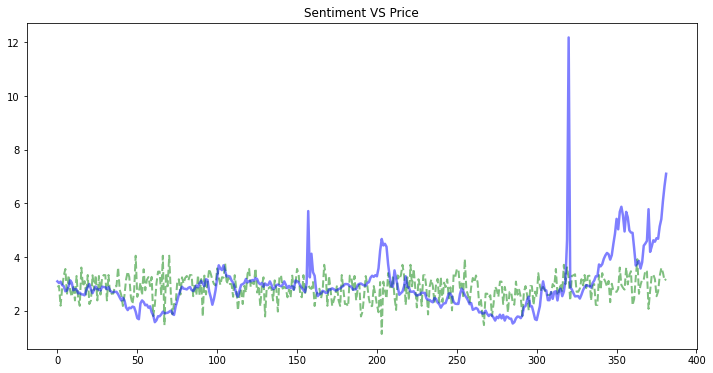

In [3]:
avg = sum(list(df.Price))/len(list(df.Price))
sen = list(df.Sentiment)
price = list(df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()